# 0.0 Imports

In [1]:
import pandas as pd
import numpy  as np

import inflection
import math
import datetime
import random
import pickle

import seaborn as sns
import xgboost as xgb

#from boruta import BorutaPy
#from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.core.display import HTML

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

## 0.1 Helper functions

In [2]:
def rename_columns(dataframe):
    df = dataframe.copy()
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df.columns)
    cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df

def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    #pd.set_option('max_columns', None, "max_rows", 50)
    pd.options.display.max_rows = 999
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKfold Number {}'. format(k))
        # start date and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)


        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] < validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))


        # store performance of each Kfold validation
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
     
    return pd.DataFrame({'Model name': model_name,
     'MAE CV' : np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
     'MAPE CV' : np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
     'RMSE CV' : np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])


In [3]:
jupyter_settings()

## 0.2 Loading data

In [4]:
df_raw_1 = pd.read_csv('../data/train.csv', low_memory=False)
df_raw_2 = pd.read_csv('../data/store.csv', low_memory=False)

In [5]:
# Merging the data, on train we have the sales date on each store for a time, and on store we have information for each store
df_raw = pd.merge(df_raw_1, df_raw_2, how='left', on='Store')

# 1.0 Data description

In [6]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [7]:
# Using the function we created in section 0.1
df1 = rename_columns(df1)

## 1.2 Data dimensions

In [8]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data types

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
#Changing the type to date
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [12]:
df1.isna().mean()

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64

## 1.5 Fillout NA 

In [13]:
# Dealing the columns with NaNs

# competition_distance - imputting 200000 distance for nan values
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if np.isnan(x) else x)

# competition_open_since_month - imputting the month of register for competition open
df1['competition_open_since_month'] = df1[['date', 'competition_open_since_month']].apply(lambda x: x['date'].month if np.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year - imptting the year of register for competition open  
df1['competition_open_since_year'] = df1[['date', 'competition_open_since_year']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
  

# promo2_since_week - imputting the week of register for promo since
df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply(lambda x: x['date'].week if np.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year - imputting the year of register for promo since
df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply(lambda x: x['date'].year if np.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval - imputting zero for promo interval
df1['promo_interval'] = df1['promo_interval'].fillna(0)

# Creating month map, then creating a column with the name of the month to check if there is a promo during the time or not
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


## 1.6 Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64', 'int32', 'float32'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]', 'int32', 'float32'])

### 1.7.1 Numerical attributes

In [17]:
df_aux = num_attributes.describe().T[['min', 'max', 'mean', 'std']]
range_ = df_aux['min'] - df_aux['max']
kurt = num_attributes.kurt(axis=0)
skew = num_attributes.skew(axis=0)

df_aux['range'] = range_
df_aux['kurt'] = kurt
df_aux['skew'] = skew

df_aux


,min,max,mean,std,range,kurt,skew
store,1.0,1115.0,558.429727,321.908651,-1114.0,-1.200524,-0.000955
day_of_week,1.0,7.0,3.998341,1.997391,-6.0,-1.246873,0.001593
sales,0.0,41551.0,5773.818972,3849.926175,-41551.0,1.778375,0.641460
customers,0.0,7388.0,633.145946,464.411734,-7388.0,7.091773,1.598650
open,0.0,1.0,0.830107,0.375539,-1.0,1.090723,-1.758045
promo,0.0,1.0,0.381515,0.485759,-1.0,-1.762018,0.487838
school_holiday,0.0,1.0,0.178647,0.383056,-1.0,0.815154,1.677842
competition_distance,20.0,200000.0,5935.442677,12547.652996,-199980.0,147.789712,10.242344
competition_open_since_month,1.0,12.0,6.786849,3.311087,-11.0,-1.232607,-0.042076
competition_open_since_year,1900.0,2015.0,2010.324840,5.515593,-115.0,124.071304,-7.235657


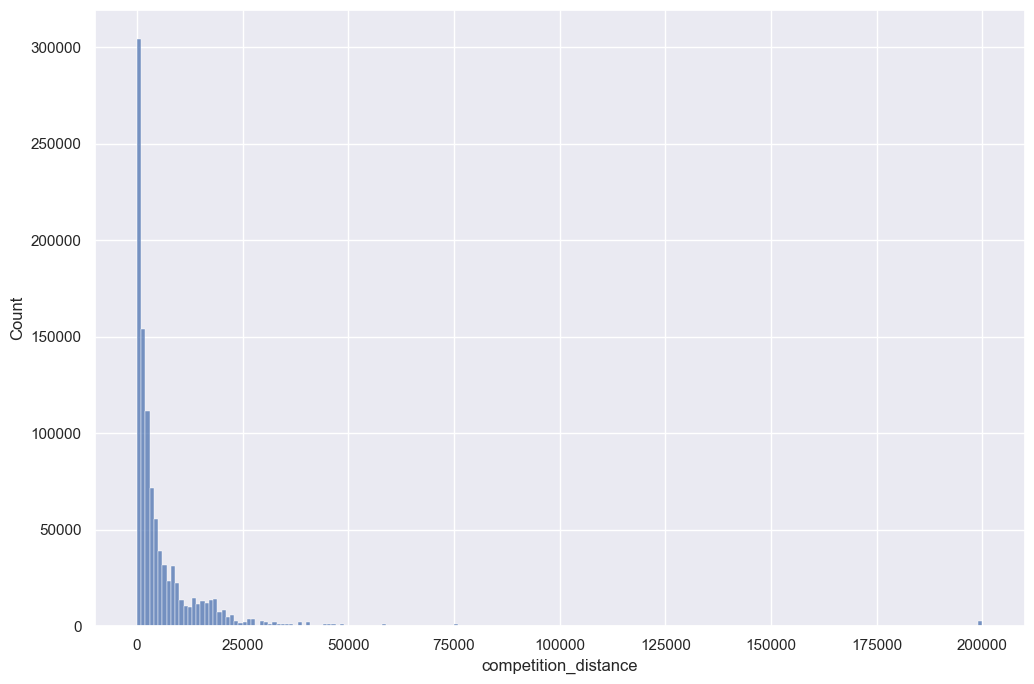

In [18]:
sns.histplot(df1['competition_distance'], kde=False, bins=200);

### 1.7.2 Categorical attributes

<Axes: xlabel='assortment', ylabel='sales'>

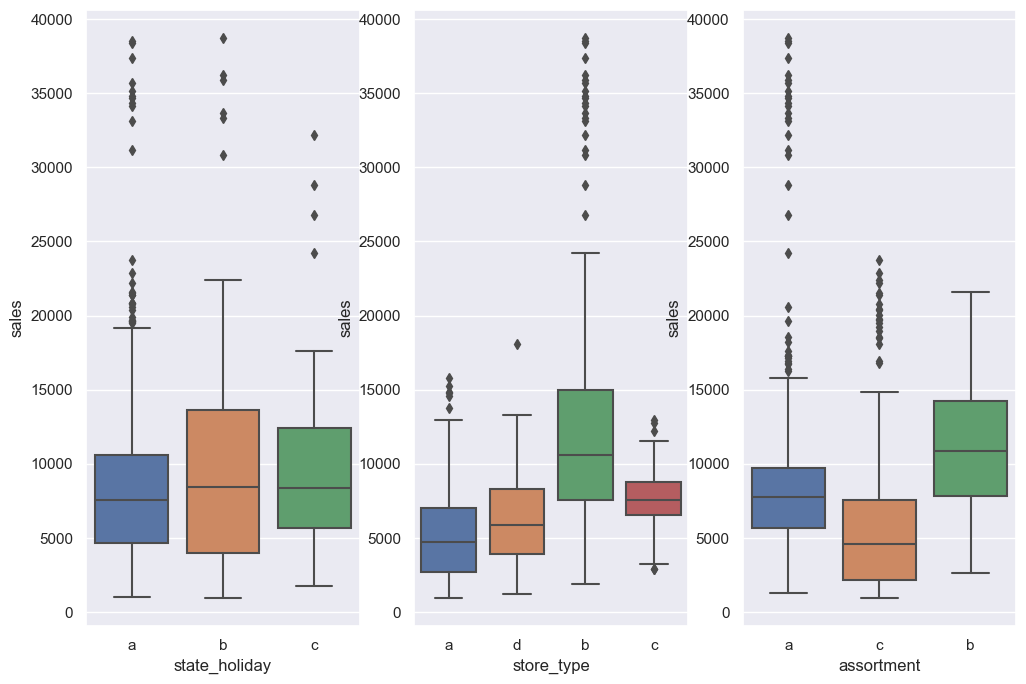

In [19]:
aux = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0) ]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

# 2.0 Feature engineering

In [20]:
df2 = df1.copy()

## 2.1 Mental map of hypothesis

## 2.2 Creating hypothesis

## 2.3 Final hypothesis

## 2.4 Feature engineering

In [21]:
# Creating a few variables to check the hypothesis

#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(int)

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7) )

# promo time week = date - promo since/7 (pega dia)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

# 3.0 Feature filtering

In [22]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [23]:
# Selecting only the days we have sales and the days the stores are open
df3 = df3[(df3['sales'] > 0) & (df3['open'] != 0)]

## 3.2 Seleção das colunas

In [24]:
# Dropping columns customers (we can't know customers will be in the stores in following days), open (we already filter for only open stores), promo interval and month map only used to create is_promo, so we don't need them
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EDA - Análise exploratória dos dados

In [25]:
df4 = df3.copy()

## 4.1 Análise univariada

### 4.1.1 Response variable

### 4.1.2 Numerical variable

### 4.1.3 Categorical variable

## 4.2 Análise bivariada

### 4.2.x Hipothesis validation

### 4.2.y Hipothesis resume

## 4.3 Análise multivariada

### 4.3.1 Numerical attributes

### 4.3.2 Categorical attributes

# 5.0 Data Preparation

In [102]:
df5 = df4.copy()

## 5.1 Normalization

There is no need to normalize because we don't see any normal distribution in section 4.1.2

## 5.2 Rescaling

Let's see the features with highest std, and select some of them to rescale

In [27]:
df_aux = df5.select_dtypes(include=['int64', 'int32', 'float64'])

df_aux = df_aux.describe().T[['min', 'max', 'mean', 'std']]
range_ = df_aux['min'] - df_aux['max']
kurt = num_attributes.kurt(axis=0)
skew = num_attributes.skew(axis=0)

df_aux['range'] = range_
df_aux['kurt'] = kurt
df_aux['skew'] = skew

df_aux.sort_values('std', ascending=False)

,min,max,mean,std,range,kurt,skew
competition_distance,20.0,200000.0,5961.827515,12592.181107,-199980.0,147.789712,10.242344
sales,46.0,41551.0,6955.959134,3103.815515,-41505.0,1.778375,0.641460
store,1.0,1115.0,558.421374,321.730861,-1114.0,-1.200524,-0.000955
promo_time_week,-126.0,313.0,54.400699,85.457559,-439.0,NaN,NaN
competition_time_month,-32.0,1407.0,41.679672,66.814412,-1439.0,NaN,NaN
week_of_year,1.0,52.0,23.646946,14.389931,-51.0,NaN,NaN
promo2_since_week,1.0,52.0,23.629083,14.288315,-51.0,-1.184046,0.178723
day,1.0,31.0,15.835706,8.683392,-30.0,NaN,NaN
competition_open_since_year,1900.0,2015.0,2010.331102,5.502628,-115.0,124.071304,-7.235657
month,1.0,12.0,5.845774,3.323959,-11.0,NaN,NaN


We selected: 
'competition_distance', 'promo_time_week', 'competition_time_month', 'week_of_year', 'promo2_since_week'

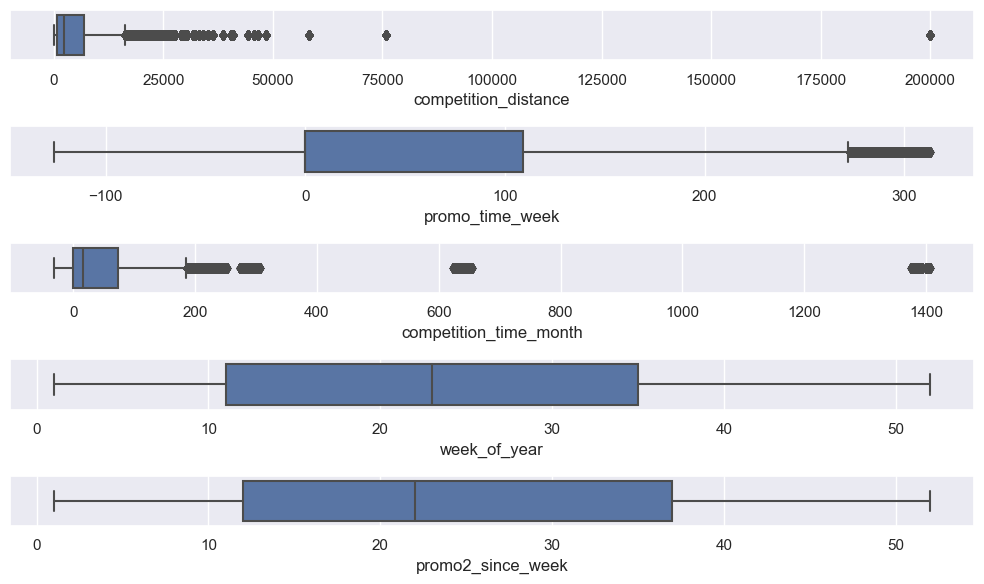

In [28]:
plt.figure(figsize=(10,6))
plt.subplot(5, 1, 1)
sns.boxplot(data=df5, x='competition_distance');

plt.subplot(5, 1, 2)
sns.boxplot(data=df5, x='promo_time_week');

plt.subplot(5, 1, 3)
sns.boxplot(data=df5, x='competition_time_month');

plt.subplot(5, 1, 4)
sns.boxplot(data=df5, x='week_of_year');

plt.subplot(5, 1, 5)
sns.boxplot(data=df5, x='promo2_since_week');

plt.tight_layout()

After we see those grapics, we will use RobustScaler for 'competition_distance', 'promo_time_week', 'competition_time_month' because they have more outliers, and MinMaxScaler for 'week_of_year', 'promo2_since_week' because they have less outliers

In [29]:
rs = RobustScaler()
mms = MinMaxScaler()

In [103]:
#RobustScaler
#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('../parameters/competition_distance_scaler.pkl', 'wb'))

#promo_time_week
df5['promo_time_week'] = rs.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('../parameters/promo_time_week_scaler.pkl', 'wb'))

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('../parameters/competition_time_month_scaler.pkl', 'wb'))

#MinMaxScaler
#week_of_year
df5['week_of_year'] = mms.fit_transform(df5[['week_of_year']].values)
pickle.dump(mms, open('../parameters/week_of_year_scaler.pkl', 'wb'))

#promo2_since_week
df5['promo2_since_week'] = mms.fit_transform(df5[['promo2_since_week']].values)
pickle.dump(mms, open('../parameters/promo2_since_week_scaler.pkl', 'wb'))

## 5.3 Transformation

In [31]:
# Let's see the features we have for enconding
df_aux = df5.select_dtypes(exclude=['int64', 'int32', 'float64']).columns
df_aux

Index(['date', 'state_holiday', 'store_type', 'assortment', 'year_week',
       'competition_since', 'promo_since'],
      dtype='object')

### 5.3.1 Encoding

Since 'date', 'year_week', 'competition_since' and 'promo_since' are cyclicar features, we will enconde 'state_holiday', 'store_type', 'assortment'

In [104]:
#state_holiday - OneHotEnconder
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('../parameters/store_type_encoder.pkl', 'wb'))

#assortment
oe = OrdinalEncoder(categories=[['basic', 'extra', 'extended']])
df5['assortment'] = oe.fit_transform(df5[['assortment']].values)
pickle.dump(le, open('../parameters/assortment_encoder.pkl', 'wb'))

### 5.3.2 Response variable transformation

In [33]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Cyclical features encoding

In [34]:
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))


#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

In [35]:
df_aux = df5.select_dtypes(exclude=['int64', 'int32', 'float64', 'bool']).columns
df_aux

Index(['date', 'year_week', 'competition_since', 'promo_since'], dtype='object')

# 6.0 Feature selection

In [36]:
df6 = df5.copy()

In [37]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

## 6.1 Splitting dataframe

In [38]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ))
print( 'Training Max Date: {}'.format( X_train['date'].max() ))

print( '\nTest Min Date: {}'.format( X_test['date'].min() ))
print( 'Test Max Date: {}'.format( X_test['date'].max() ))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Feature Selection - Select KBest

In [39]:
from sklearn.feature_selection import SelectKBest, f_regression

In [40]:
k_best = SelectKBest(f_regression, k=16)

In [41]:
X_train_n = X_train.drop( ['date', 'sales'], axis=1 )
X_test_n = X_test.drop( ['date', 'sales'], axis=1 )
y_train_n = y_train

In [42]:
X_train_best = k_best.fit_transform(X_train_n, y_train_n)

In [43]:
X_test_best = k_best.transform(X_test_n)

In [45]:
cols_kbest_raw = k_best.get_feature_names_out().tolist()

In [50]:
cols_kbest_raw = ['promo',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'is_promo',
 'year',
 'promo_time_week',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin']

## 6.3 Manual feature selection

In [56]:
# We add day_of_week_cos because we already had day_of_week_sin selected by SelectKBest
cols_kbest = ['store', 'promo',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'is_promo',
 'year',
 'promo_time_week',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# columns to add - we will need them for cross validation furthermore
feat_to_add = ['date', 'sales']

cols_kbest_full = cols_kbest.copy()
cols_kbest_full.extend( feat_to_add )

# 7.0 Machine Learning Modelling

In [57]:
x_train = X_train[cols_kbest]
x_test =  X_test[cols_kbest]

#time series preparation
x_training = X_train[cols_kbest_full]

## 7.1 Baseline model - Average

In [59]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})

aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear regression model

In [60]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression Model', np.expm1(y_test), np.expm1(yhat_lr))

lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Model,1872.339851,0.294928,2672.654291


### 7.2.1 Linear regression model - Cross validation

In [61]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2077.67 +/- 283.49,0.29 +/- 0.01,2979.67 +/- 435.96


## 7.3 Random Forest 

In [62]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=22).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))

rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,689.941663,0.102309,1022.075802


### 7.4.1 Random Forest  - Cross validation

In [63]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf, verbose=True)
rf_result_cv


Kfold Number 5

Kfold Number 4

Kfold Number 3

Kfold Number 2

Kfold Number 1


,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,804.73 +/- 185.4,0.11 +/- 0.02,1196.03 +/- 272.75


## 7.5 XGBoost Regrssor

In [64]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.1,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

#prediction
yhat_xgb = rf.predict(x_test)

#performance
xgb_result = ml_error('XGB Regressor', np.expm1(y_test), np.expm1(yhat_xgb))

xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGB Regressor,729.254371,0.107676,1074.693209


### 7.5.1 XGBoost Regressor - Cross Validation

In [65]:
xgb_result_cv = cross_validation(x_training, 5, 'XGB Regressor', model_xgb, verbose=True)
xgb_result_cv


Kfold Number 5

Kfold Number 4

Kfold Number 3

Kfold Number 2

Kfold Number 1


,Model name,MAE CV,MAPE CV,RMSE CV
0,XGB Regressor,1079.85 +/- 162.9,0.15 +/- 0.01,1557.28 +/- 229.63


## 7.6 Compare Model's Performance


### 7.6.1 Single performance

In [66]:
modelling_result = pd.concat( [baseline_result, lr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,689.941663,0.102309,1022.075802
0,XGB Regressor,729.254371,0.107676,1074.693209
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression Model,1872.339851,0.294928,2672.654291


### 7.6.2 Real performance - Cross validation

In [67]:
modelling_result_cv = pd.concat( [lr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE CV' )

,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,804.73 +/- 185.4,0.11 +/- 0.02,1196.03 +/- 272.75
0,XGB Regressor,1079.85 +/- 162.9,0.15 +/- 0.01,1557.28 +/- 229.63
0,Linear Regression,2077.67 +/- 283.49,0.29 +/- 0.01,2979.67 +/- 435.96


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random search

In [58]:
#param = {
#    'n_estimators': [1500, 1700, 2000, 2500, 3000, 3500],
#    'eta': [0.01, 0.02, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]    
#}
#MAX_EVAL = 5

In [59]:
#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
#    #choose values for parameters randomly
#    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
#    print(hp)
#    
#    # model
#    
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                            n_estimators=hp['n_estimators'],
#                             eta=hp['eta'],
#                             max_depth=hp['max_depth'],
#                             subsample=hp['subsample'],
#                             colsample_bytree=hp['colsample_bytree'])
#    
#    # performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#    
#    final_result = pd.concat([final_result, result])
#
#final_result

## 8.2 - Final model

In [68]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
}

model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'],
                             eta=param_tuned['eta'],
                             max_depth=param_tuned['max_depth'],
                             subsample=param_tuned['subsample'],
                             colsample_bytree=param_tuned['colsample_bytree'],
                            min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)
    
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

xgb_result_tuned


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,774.716316,0.11695,1117.396832


In [69]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.0175751229651615

# 9.0 Error analysis

In [80]:
df9 = X_test[cols_kbest_full].copy()

# rescale
df9.loc[:,'sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)


## 9.1 Business performance

In [81]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']
# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]


In [83]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
732,733,625663.625000,624915.770894,626411.479106,747.854106,0.049899
1066,1067,223747.218750,223402.270191,224092.167309,344.948559,0.055745
762,763,234915.671875,234557.478436,235273.865314,358.193439,0.058377
725,726,402067.312500,401438.648160,402695.976840,628.664340,0.058645
254,255,232305.203125,231914.650879,232695.755371,390.552246,0.060007


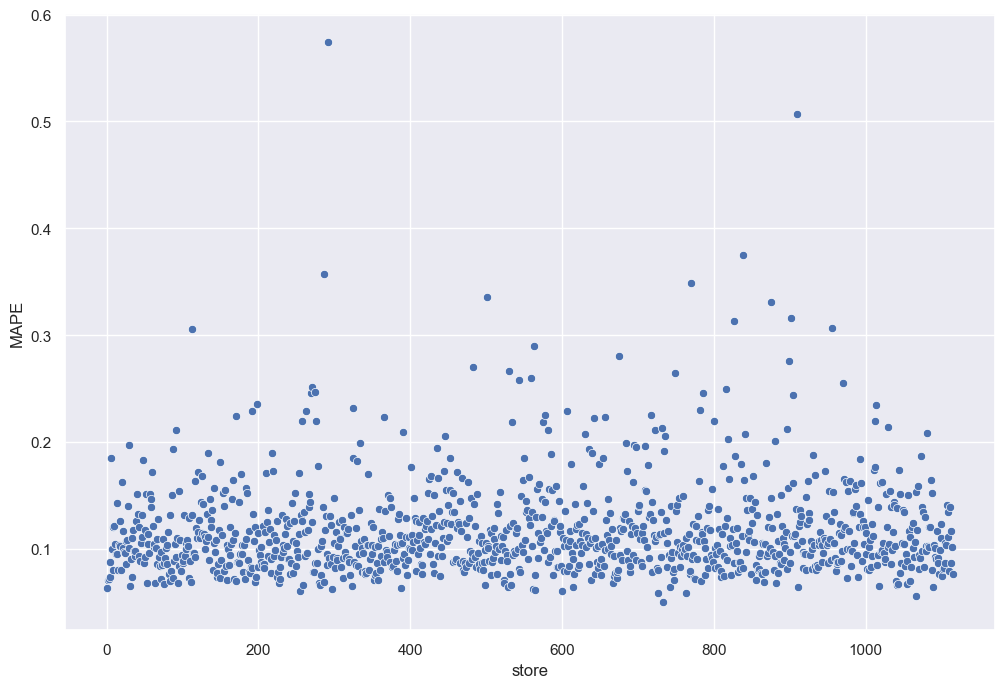

In [85]:
sns.scatterplot( x='store', y='MAPE', data=df92 );

## 9.2 Total performance

In [89]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map( '${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"$285,297,856.00"
1,worst_scenario,"$284,430,724.03"
2,best_scenario,"$286,164,951.37"


## 9.3 Machine learning perfomance

In [90]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<Axes: xlabel='predictions', ylabel='error'>

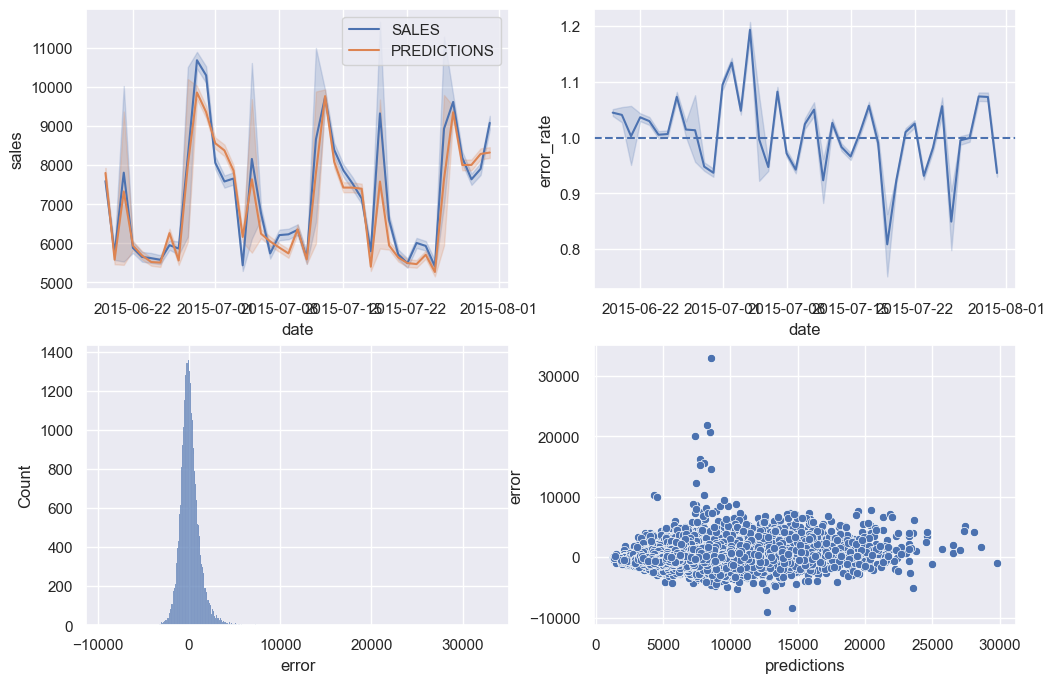

In [97]:
plt.subplot( 2, 2, 1 )
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot( 2, 2, 2 )
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.histplot(df9['error'])

plt.subplot( 2, 2, 4 )
sns.scatterplot(x='predictions', y='error', data=df9)

# 10.0 Deploy model to production

In [100]:
pickle.dump(model_xgb_tuned, open('../models/model_rossmann_xgb_1.pkl', 'wb'))

## 10.1 Rossmann Class

In [105]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math


class Rossmann(object):
    def __init__(self):
        # self.home_path = 
        self.competition_distance_scaler   = pickle.load(open('../parameters/competition_distance_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open('../parameters/promo_time_week_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open('../parameters/competition_time_month_scaler.pkl', 'rb'))
        self.week_of_year_scaler           = pickle.load(open('../parameters/week_of_year_scaler.pkl', 'rb'))
        self.promo2_since_week_scaler      = pickle.load(open('../parameters/promo2_since_week_scaler.pkl', 'rb'))
        self.store_type_encoder            = pickle.load(open('../parameters/store_type_encoder.pkl', 'rb'))
        self.assortment_encoder            = pickle.load(open('../parameters/assortment_encoder.pkl', 'rb'))

        
    def data_cleaning(self, df1):

        ## 1.1 Rename columns

        # Using the function we created in section 0.1
        df1 = rename_columns(df1)

        ## 1.3 Data types

        #Changing the type to date
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fillout NA 

        # Dealing the columns with NaNs

        # competition_distance - imputting 200000 distance for nan values
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if np.isnan(x) else x)

        # competition_open_since_month - imputting the month of register for competition open
        df1['competition_open_since_month'] = df1[['date', 'competition_open_since_month']].apply(lambda x: x['date'].month if np.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year - imptting the year of register for competition open  
        df1['competition_open_since_year'] = df1[['date', 'competition_open_since_year']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


        # promo2_since_week - imputting the week of register for promo since
        df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply(lambda x: x['date'].week if np.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year - imputting the year of register for promo since
        df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply(lambda x: x['date'].year if np.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


        # promo_interval - imputting zero for promo interval
        df1['promo_interval'] = df1['promo_interval'].fillna(0)

        # Creating month map, then creating a column with the name of the month to check if there is a promo during the time or not
        month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


        ## 1.6 Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
    
        return df1

    def feature_engineering(self, df2):
        
        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(int)

        #year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7) )

        # promo time week = date - promo since/7 (pega dia)
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        #assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

        # 3.0 Feature filtering

        ## 3.1 Filtragem das linhas

        # Selecting only the days we have sales and the days the stores are open
        df2 = df2[(df2['sales'] > 0) & (df2['open'] != 0)]

        ## 3.2 Seleção das colunas

        # Dropping columns customers (we can't know customers will be in the stores in following days), open (we already filter for only open stores), promo interval and month map only used to create is_promo, so we don't need them
        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
    
        return df2

    def data_preparation(self, df5):
        
        ## 5.2 Rescaling

        #RobustScaler
        #competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        

        #competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        #MinMaxScaler
        #week_of_year
        df5['week_of_year'] = self.week_of_year_scaler.fit_transform(df5[['week_of_year']].values)
        

        #promo2_since_week
        df5['promo2_since_week'] = self.promo2_since_week_scaler.fit_transform(df5[['promo2_since_week']].values)
        
        
        ## 5.3 Transformation
        ### 5.3.1 Encoding
        
        #state_holiday - OneHotEnconder
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        #store_type
        df5['store_type'] = self.store_type_encoder.fit_transform(df5['store_type'])
        

        #assortment
        df5['assortment'] = self.assortment_encoder.fit_transform(df5[['assortment']].values)

        ### 5.3.3 Cyclical features encoding

        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))


        #week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

        #day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))
        
        cols_selected = ['store', 'promo','school_holiday', 'store_type', 'assortment', 'competition_distance', 'promo2', 'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'promo_time_week', 'day_sin', 
                         'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']

        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')
    

## 10.2 API Handler

In [109]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('../models/model_rossmann_xgb_1.pkl', 'rb'))

app = Flask(__name__)

@app.route('/rossmann/predict/', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Rossmann Class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipieline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [6]:
import requests

In [34]:
df10 = pd.read_csv('../data/test.csv')

In [35]:
# merge test dataset
df_test = pd.merge(df10, df_raw_2, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'] == 22]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [36]:
# convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [50]:
# API Call
url = 'http://127.0.0.1:5000/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [51]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [53]:
d1.head()

,store,promo,school_holiday,store_type,assortment,competition_distance,promo2,promo2_since_week,promo2_since_year,is_promo,year,promo_time_week,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,prediction
0,22,1,0,0,0,0.0,1,0.0,2012,0,2015,0.923077,-4.067366e-01,-0.913545,0.120537,0.992709,-0.433884,-0.900969,7177.167969
1,22,1,0,0,0,0.0,1,0.0,2012,0,2015,0.923077,-2.079117e-01,-0.978148,0.120537,0.992709,0.433884,-0.900969,7302.595215
2,22,1,0,0,0,0.0,1,0.0,2012,0,2015,0.923077,1.224647e-16,-1.000000,0.120537,0.992709,0.974928,-0.222521,7994.691406
3,22,1,1,0,0,0.0,1,0.0,2012,0,2015,0.923077,2.079117e-01,-0.978148,0.120537,0.992709,0.781831,0.623490,9783.779297
4,22,0,0,0,0,0.0,1,0.0,2012,0,2015,0.615385,5.877853e-01,-0.809017,0.103384,0.994642,-0.781831,0.623490,3227.774170


In [40]:
d2 = d1[['Store', 'prediction']].groupby('Store').sum().reset_index()

In [41]:
d2

,Store,prediction
0,22,194289.872803


In [43]:
data

'[{"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 3, "Date": "2015-09-16", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 2, "Date": "2015-09-15", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.